In [1]:
import pandas as pd
import numpy as np
import re
#import math
#from random import choices
#import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#import statistics

In [2]:
import devanalyst.simulation.statics as S_

from devanalyst.simulation.businessObjects import WorkAssignments, ReleaseCycleContext, Ticket
from devanalyst.simulation.simulationModels import BalancedAllocationModel, GreedyAllocationModel, ModelsConfig, \
Distribution, DefaultCostModel, QualityModel

import devanalyst.simulation.generateTimecards as timecard
#from devanalyst.simulation.generateTimecards import WorkAssignments


importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\businessObjects.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\simulationModels.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\generateTimecards.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


In [4]:
import devanalyst.simulation.visualizations.simm_visuals as simm_visuals
import devanalyst.simulation.visualizations.timecard_visuals as tc_visuals

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\visualizations\simm_visuals.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\visualizations\timecard_visuals.ipynb


<h1>Pilots</h1>

<h2>Bug inflow prototypes</h2>

In [5]:
class DistributedLagQualityModel(QualityModel):

    def __init__(self):
        super(DistributedLagQualityModel, self).__init__()
        return
    
    # Returns a list of Ticket instances.
    # -modelsConfig: a ModelsConfig instance
    def findBugs(self, modelsConfig): 
        uss_list = DistributedLagQualityModel._findFinishedStories(modelsConfig.context)
        
        bugs = []
        current_sprint = modelsConfig.context.sprint
        for uss in uss_list:
            delivery_sprint = uss.sprintDelivered
            lag = current_sprint - delivery_sprint
            story = modelsConfig.context.storiesRepo.findStory(uss.userStoryId)
            story_bugs = DistributedLagQualityModel._findDefectsInStory(lag, story, modelsConfig)
            bugs.extend(story_bugs)
        return bugs

    # Returns a list of UserStoryStatus instances, corresponding to all user stories that have been finished.
    def _findFinishedStories(context):
        uss_list = []
        ids = context.storiesRepo.findIds()
        for userStoryId in ids:
            uss = context.teamsRepo.getUserStoryStatus(userStoryId)
            if (uss.percentAchieved == 1.0):
                uss_list.append(uss)
        return uss_list
    
    # Returns a list of Ticket instances
    def _findDefectsInStory(lag, userStory, modelsConfig):
        if lag < 1 or lag > 3: # No bugs for stories just finished or which were finished a while ago
            return []
        # Exposure is the probability of finding a bug. For now hardcode a 50% exposure distributed over 
        # 3 sprints with the surge in the middle one
        if lag == 1:
            exposure = 0.125
        if lag == 2:
            exposure = 0.25
        if lag == 3:
            exposure = 0.125
        possible_defect_count  = [0, 1] # Possible values for number of bugs found
        likelihoods            = [1-exposure, exposure]
        defect_count           = modelsConfig.random.pickOneWithWeights(possible_defect_count, likelihoods)
        
        # Issue defect Tickets
        defects = []
        repo = modelsConfig.context.ticketsRepo
        for i in range(defect_count):
            costToFix = DistributedLagQualityModel._estimateCostToFix(userStory, modelsConfig)
            ticketId = repo._nextTicketId()
            ticket = Ticket(ticketId, userStory.userStoryId, costToFix, modelsConfig.context.sprint)
            repo.addTicket(ticket)
            defects.append(ticket)
        return defects
    
        
    def _estimateCostToFix(userStory, modelsConfig):
    # For now hard-code a simplistic cost to fix: each bug costs 20% of the original estimate of the story.
    # Better would be a percentage of the actual cost to develop.
         return 0.20 * userStory.originalEstimate


In [6]:
def testTicketInflow(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    TEAM_ID = 'Team A'
    SPRINT = 1    
    ctx = ReleaseCycleContext(TEAM_ID, teamsRepo, storiesRepo, ticketsRepo, SPRINT, SPRINT_DURATION)
    modelsConfig.context = ctx

    # Pretend all stories have been completed on the first sprint
    uss_list = []
    ids = ctx.storiesRepo.findIds()
    for userStoryId in ids:
        uss = ctx.teamsRepo.getUserStoryStatus(userStoryId)
        uss.percentAchieved = 1.0
        uss.planned = True
        uss.sprintPlanned = 1
        uss.sprintDelivered = 1
    
    # Now pretend we raverse the next 5 sprints, generating bugs
    bugs = []
    for i in range(5):
        ctx.sprint = SPRINT + i + 1
        qualityModel = modelsConfig.qualityModels[0]
        bugs.extend(qualityModel.findBugs(modelsConfig))
    return bugs

In [7]:
# -bugs: a list of Tickets
def build_bugs_df(bugs):
    bugs_dict = {}
    bugs_dict['Ticket Id']        = []
    bugs_dict['User Story Id']    = []
    bugs_dict['Estimated Cost']   = []
    bugs_dict['Effort to Date']   = []
    bugs_dict['Percent Achieved'] = []
    bugs_dict['Sprint Reported']  = []
    bugs_dict['Sprint Fixed']     = []
    
    for bug in bugs:
        bugs_dict['Ticket Id']        .append(bug.ticketId)
        bugs_dict['User Story Id']    .append(bug.userStoryId)
        bugs_dict['Estimated Cost']   .append(bug.estimatedCost)
        bugs_dict['Effort to Date']   .append(bug.effortToDate)
        bugs_dict['Percent Achieved'] .append(bug.percentAchieved)
        bugs_dict['Sprint Reported']  .append(bug.sprintReported)
        bugs_dict['Sprint Fixed']     .append(bug.sprintFixed)
        
    bugs_df = pd.DataFrame(bugs_dict)
    return bugs_df

In [8]:
# -modelsConfig
def build_stories_df(modelsConfig):
    stories_dict = {}
    cols = ['User Story Id', 'Original Estimate', 'Developer', 'Product Manager', 'Percent Achieved', \
            'Planned', 'Sprint Planned', 'Sprint Delivered', 'Open Bugs', 'Closed Bugs']
    for c in cols:
        stories_dict[c] = []
    
    storiesRepo    = modelsConfig.context.storiesRepo
    teamsRepo      = modelsConfig.context.teamsRepo
    ticketsRepo    = modelsConfig.context.ticketsRepo
    for storyId in storiesRepo.findIds():
        story        = storiesRepo.findStory(storyId)
        uss          = teamsRepo.getUserStoryStatus(storyId)
        open_bugs    = ticketsRepo.getOpenTickets(storyId)
        closed_bugs  = ticketsRepo.getClosedTickets(storyId)
        
        
        open_bugs_ids = []
        for bug in open_bugs:
            open_bugs_ids.append(bug.ticketId)
            
        closed_bugs_ids = []
        for bug in closed_bugs:
            closed_bugs_ids.append(bug.ticketId)

        
        stories_dict['User Story Id']       .append(story.userStoryId)
        stories_dict['Original Estimate']   .append(story.originalEstimate)
        stories_dict['Developer']           .append(story.developer)
        stories_dict['Product Manager']     .append(story.productManager)
        stories_dict['Percent Achieved']    .append(uss.percentAchieved)
        stories_dict['Planned']             .append(uss.planned)
        stories_dict['Sprint Planned']      .append(uss.sprintPlanned)
        stories_dict['Sprint Delivered']    .append(uss.sprintDelivered)        
        stories_dict['Open Bugs']           .append(open_bugs_ids)        
        stories_dict['Closed Bugs']         .append(closed_bugs_ids)        
        
    stories_df = pd.DataFrame(stories_dict)
    return stories_df

In [9]:
modelsConfig = ModelsConfig([DefaultCostModel(0.25)], [DistributedLagQualityModel()], GreedyAllocationModel()) 
modelsConfig.random.reset(271)
bugs = testTicketInflow(modelsConfig)
bugs_df = build_bugs_df(bugs)
bugs_df[:6]

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #1,UserStory #3,0.8,0.0,0.0,2,NOT_SET
1,Ticket #2,UserStory #10,1.8,0.0,0.0,2,NOT_SET
2,Ticket #3,UserStory #15,0.6,0.0,0.0,2,NOT_SET
3,Ticket #4,UserStory #22,0.6,0.0,0.0,2,NOT_SET
4,Ticket #5,UserStory #30,0.4,0.0,0.0,2,NOT_SET
5,Ticket #6,UserStory #36,2.0,0.0,0.0,2,NOT_SET


In [10]:
bugs_df['Estimated Cost'].sum()

160.2

In [11]:
stories_df = build_stories_df(modelsConfig)
stories_df

,User Story Id,Original Estimate,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Open Bugs,Closed Bugs
0,UserStory #1,10,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,[Ticket #122],[]
1,UserStory #2,10,Glenna Mcghie,Sherlyn Cordle,1.0,True,1,1,[Ticket #40],[]
2,UserStory #3,4,Francisco Hoppe,Edgar Hibbler,1.0,True,1,1,"[Ticket #1, Ticket #41]",[]
3,UserStory #4,7,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,[Ticket #42],[]
4,UserStory #5,3,Gregorio Darr,Edgar Hibbler,1.0,True,1,1,[],[]
5,UserStory #6,3,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,[Ticket #43],[]
6,UserStory #7,8,Anton Easterday,Sherlyn Cordle,1.0,True,1,1,[],[]
7,UserStory #8,9,Anton Easterday,Edgar Hibbler,1.0,True,1,1,[],[]
8,UserStory #9,9,Gregorio Darr,Sherlyn Cordle,1.0,True,1,1,[],[]
9,UserStory #10,9,Gregorio Darr,Sherlyn Cordle,1.0,True,1,1,[Ticket #2],[]


In [12]:
stories_df['Original Estimate'].sum()

1686

In [13]:
def countUniques(seriesGroup):
    if (seriesGroup.unique()[0] == None):
        return 0
    else:
        return seriesGroup.unique().size

In [14]:
countUniques(bugs_df['User Story Id'])

132

In [15]:
bugs_df.shape

(155, 7)

In [16]:
modelsConfig.context.sprint

6

In [17]:
def genReleaseCycleSheets(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, releaseLog = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, releaseLog, teamsRepo, storiesRepo

In [18]:
SPRINT_DURATION = 10
modelsConfig = ModelsConfig([DefaultCostModel(0.0)], [DistributedLagQualityModel()], GreedyAllocationModel()) 
modelsConfig.random.reset(271)
entries_df, releaseLog, TEAMS_REPO, STORIES_REPO = genReleaseCycleSheets(modelsConfig)

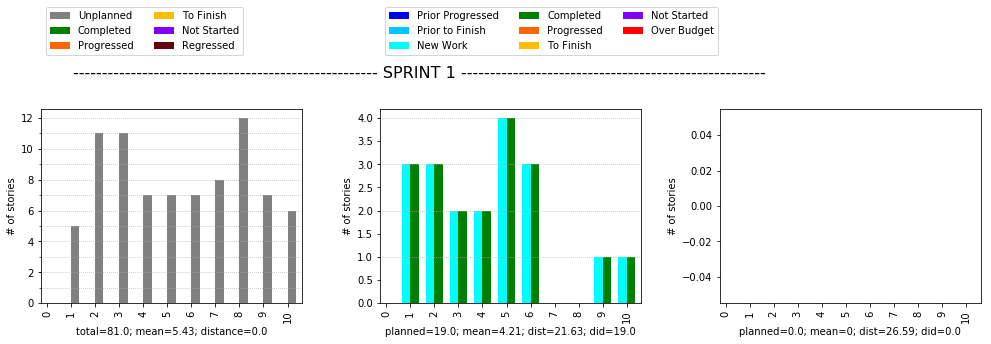

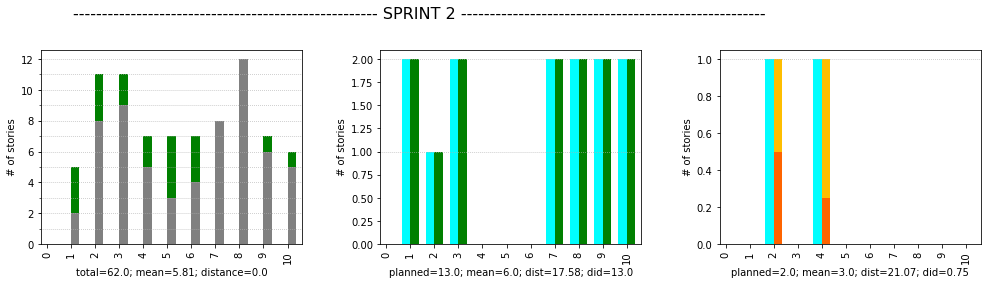

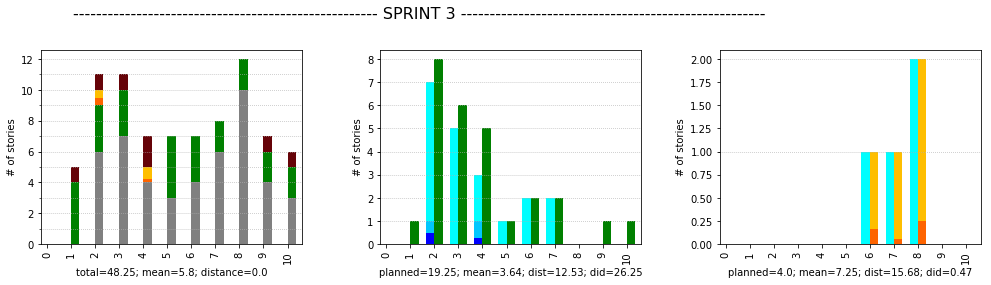

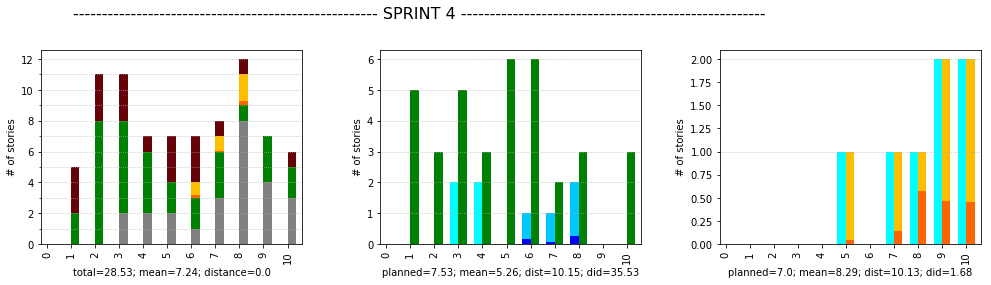

In [21]:
tc_visuals.renderReleaseCycleLog('Team A', releaseLog, 1, 4)

In [22]:
stories_df = build_stories_df(modelsConfig)
stories_df[:6]

,User Story Id,Original Estimate,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Open Bugs,Closed Bugs
0,UserStory #1,10,Bruno Studley,Sherlyn Cordle,1.0,True,2,2,[],"[Ticket #137, Ticket #213]"
1,UserStory #2,10,Craig Garlitz,Sherlyn Cordle,1.0,True,4,5,[],[]
2,UserStory #3,4,Beau Hockensmith,Edgar Hibbler,1.0,True,4,4,[],[]
3,UserStory #4,7,Bruno Studley,Sherlyn Cordle,1.0,True,5,6,[],"[Ticket #455, Ticket #497, Ticket #509]"
4,UserStory #5,3,Glenna Mcghie,Edgar Hibbler,1.0,True,3,3,[],"[Ticket #138, Ticket #261, Ticket #361, Ticket..."
5,UserStory #6,3,Craig Garlitz,Sherlyn Cordle,1.0,True,3,3,[],"[Ticket #287, Ticket #343]"


In [23]:
bugs = modelsConfig.context.ticketsRepo.getClosedTickets('UserStory #8')
bugs_df = build_bugs_df(bugs)
bugs_df

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #6,UserStory #8,1.8,1.8,1.0,2,3


In [24]:
entries_df[entries_df['User Story'] == 'UserStory #8']

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
11,1,2018-01-29,Team A,Francisco Hoppe,UserStory #8,UNFINISHED_STORIES,Story implementation,9.0
169,3,2018-02-26,Team A,Francisco Hoppe,UserStory #8,DEV_TIME_BUGS,Ticket #6,1.8


In [25]:
df = releaseLog.log['Team A'][4]['Outcome']
df[df['Owner'] == 'Anton Easterday']

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,DEV_TIME_BUGS,Ticket #32,UserStory #23,4,4,0.4,CURRENT_SPRINT,0.4,0.0,1.0
1,Anton Easterday,DEV_TIME_BUGS,Ticket #118,UserStory #64,4,4,0.8,CURRENT_SPRINT,0.8,0.0,1.0
2,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #75,3,4,7.0,CURRENT_SPRINT,7.0,0.0,1.0
3,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #21,4,4,9.0,NEXT_SPRINT,1.8,7.2,0.2


In [26]:
df = releaseLog.log['Team A'][3]['Outcome']
df

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,DEV_TIME_BUGS,Ticket #7,UserStory #23,3,3,0.4,CURRENT_SPRINT,0.4,0.0,1.000000
1,Anton Easterday,DEV_TIME_BUGS,Ticket #24,UserStory #58,3,3,0.8,CURRENT_SPRINT,0.8,0.0,1.000000
2,Anton Easterday,DEV_TIME_BUGS,Ticket #25,UserStory #64,3,3,0.8,CURRENT_SPRINT,0.8,0.0,1.000000
3,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #56,3,3,5.0,CURRENT_SPRINT,5.0,0.0,1.000000
4,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #60,3,3,2.0,CURRENT_SPRINT,2.0,0.0,1.000000
5,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #75,3,3,8.0,NEXT_SPRINT,1.0,7.0,0.125000
6,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #50,3,3,6.0,CURRENT_SPRINT,6.0,0.0,1.000000
7,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #72,3,3,2.0,CURRENT_SPRINT,2.0,0.0,1.000000
8,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #31,3,3,2.0,CURRENT_SPRINT,2.0,0.0,1.000000
9,Bruno Studley,DEV_TIME_BUGS,Ticket #14,UserStory #22,3,3,0.6,CURRENT_SPRINT,0.6,0.0,1.000000


In [27]:
dfe = releaseLog.log['Team A'][3]['planned_End_CURRENT_SPRINT']
dfe

,Breakout,0,1,2,3,4,5,6,7,8,9,10
0,Completed,0.0,1.0,8.0,6.0,5.0,1.0,2.0,2.0,0.0,1.0,1.0
1,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Over Budget,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
dfs = releaseLog.log['Team A'][3]['planned_Start_CURRENT_SPRINT']
dfs

,Breakout,0,1,2,3,4,5,6,7,8,9,10
0,Prior Progressed,0.0,0.0,0.5,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
1,Prior to Finish,0.0,0.0,0.5,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0
2,New Work,0.0,0.0,6.0,5.0,2.00,1.0,2.0,2.0,0.0,0.0,0.0


In [29]:
dfbl = releaseLog.log['Team A'][3]['backlog']
dfbl

,Breakout,0,1,2,3,4,5,6,7,8,9,10
0,Unplanned,0.0,0.0,6.0,7.0,4.00,3.0,4.0,6.0,10.0,4.0,3.0
1,Completed,0.0,4.0,3.0,3.0,0.00,4.0,3.0,2.0,2.0,2.0,2.0
2,Progressed,0.0,0.0,0.5,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
3,To Finish,0.0,0.0,0.5,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0
4,Not Started,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,Regressed,0.0,1.0,1.0,1.0,2.00,0.0,0.0,0.0,0.0,1.0,1.0


In [31]:
bugs_df = build_bugs_df(modelsConfig.context.ticketsRepo.tickets)
c1 = bugs_df['Sprint Reported'] < 3
c2 = bugs_df['Sprint Fixed'] > 2
b3 = bugs_df[c1 & c2]
b3

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
9,Ticket #6,UserStory #8,1.8,1.8,1.0,2,3
10,Ticket #1,UserStory #17,2.0,2.0,1.0,2,3
11,Ticket #14,UserStory #22,0.6,0.6,1.0,2,3
12,Ticket #7,UserStory #23,0.4,0.4,1.0,2,3
13,Ticket #24,UserStory #58,0.8,0.8,1.0,2,3
14,Ticket #25,UserStory #64,0.8,0.8,1.0,2,3
15,Ticket #15,UserStory #71,0.2,0.2,1.0,2,3
17,Ticket #16,UserStory #96,0.8,0.8,1.0,2,3
18,Ticket #8,UserStory #110,0.6,0.6,1.0,2,3
19,Ticket #26,UserStory #110,0.6,0.6,1.0,2,3


In [32]:
b3['User Story Id'].unique()

array(['UserStory #8', 'UserStory #17', 'UserStory #22', 'UserStory #23',
       'UserStory #58', 'UserStory #64', 'UserStory #71', 'UserStory #96',
       'UserStory #110', 'UserStory #114', 'UserStory #124',
       'UserStory #128', 'UserStory #129', 'UserStory #144',
       'UserStory #145', 'UserStory #146', 'UserStory #159',
       'UserStory #160', 'UserStory #195', 'UserStory #201',
       'UserStory #308'], dtype=object)

In [33]:
b3.shape

(22, 7)

In [34]:
df = releaseLog.log['Team A'][3]['Outcome']
df[df['Task Type'] == 'DEV_TIME_BUGS']

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,DEV_TIME_BUGS,Ticket #7,UserStory #23,3,3,0.4,CURRENT_SPRINT,0.4,0.0,1.0
1,Anton Easterday,DEV_TIME_BUGS,Ticket #24,UserStory #58,3,3,0.8,CURRENT_SPRINT,0.8,0.0,1.0
2,Anton Easterday,DEV_TIME_BUGS,Ticket #25,UserStory #64,3,3,0.8,CURRENT_SPRINT,0.8,0.0,1.0
9,Bruno Studley,DEV_TIME_BUGS,Ticket #14,UserStory #22,3,3,0.6,CURRENT_SPRINT,0.6,0.0,1.0
17,Francisco Hoppe,DEV_TIME_BUGS,Ticket #6,UserStory #8,3,3,1.8,CURRENT_SPRINT,1.8,0.0,1.0
18,Francisco Hoppe,DEV_TIME_BUGS,Ticket #15,UserStory #71,3,3,0.2,CURRENT_SPRINT,0.2,0.0,1.0
21,Glenna Mcghie,DEV_TIME_BUGS,Ticket #1,UserStory #17,3,3,2.0,CURRENT_SPRINT,2.0,0.0,1.0


<h2>Burnout in release cycle - Pilot</h2>

In [ ]:
# 
def genReleaseCycle(modelsConfig):
    RELEASE_DURATION = 60
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets, storiesRepo

In [ ]:
def genBurnout(entries_df, storiesRepo):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo, storiesRepo)
    
    
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    

    return burnout, u

In [ ]:
def storyInfo(group_df, storiesRepo):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    '''
    userStoryId = group_df['User Story']
    userStory = storiesRepo.findStory(userStoryId)
    info['Original estimate'] = userStory.originalEstimate    
    '''
    
    return pd.DataFrame(info)

In [ ]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [ ]:
SPRINT_DURATION = 10
modelsConfig1 = ModelsConfig([DefaultCostModel(0.0)], [], BalancedAllocationModel(SPRINT_DURATION)) 
modelsConfig1.random.reset(271)
entries_df1, worksheets1, storiesRepo = genReleaseCycle(modelsConfig1)

In [ ]:
burn1, u1 = genBurnout(entries_df1, storiesRepo)
burn1

In [ ]:
u1

In [ ]:
SPRINT_DURATION = 10
modelsConfig2 = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig2.random.reset(271)
entries_df2, worksheets2, storiesRepo = genReleaseCycle(modelsConfig2)

In [ ]:
burn2, u2 = genBurnout(entries_df2, storiesRepo)
burn2

In [ ]:
burn1['Effort'].plot(label = 'Balanced'), burn2['Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
burn1['Avg Effort'].plot(label = 'Balanced'), burn2['Avg Effort'].plot(label = 'Greedy'), plt.legend()

In [ ]:
u1_10 = u1[u1['Final Sprint'] == 10]
u1_10.shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10]['Effort'].mean()

In [ ]:
u1_10['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 10].shape

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9]['Effort'].mean()

In [ ]:
u1_10[u1_10['Initial Sprint'] == 9].shape